In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

In [63]:
results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_cross_context_stimulus_decoding_20260129_231436/"

In [64]:
results_table=pl.read_parquet(results_path)

In [76]:
results_table.filter(
    pl.col('structure').eq('MOs'),
    pl.col('bin_center').eq(0.125),
    pl.col('train_test_split_label').eq('train_vis_test_vis'),
)['balanced_accuracy_test'].mean()


0.578439664706684

In [ ]:
# results_table.filter(
#     pl.col('structure').eq('PL'),
#     pl.col('bin_center').eq(0.125),
#     pl.col('train_test_split_label').eq('train_vis_test_vis'),
# )

In [57]:
results_table['structure'].unique()

structure
str
"""CP"""
"""GU"""
"""ORBm"""
"""ACAv"""
"""ACAd"""
…
"""MOs"""
"""SSp"""
"""TTd"""


In [79]:
results_table

balanced_accuracy_test,balanced_accuracy_train,time_aligned_to,bin_size,sliding_window_size,bin_center,shift_idx,repeat_idx,labels,train_test_split_label,decision_function,decision_function_all,predict_proba,predict_proba_all_trials,trial_indices,unit_ids,coefs,is_all_trials,session_id,structure,electrode_group_names,unit_subsample_size,unit_criteria
f64,f64,enum,f64,f64,f64,i16,u16,list[i64],str,list[f64],list[f64],list[f64],list[f64],list[u16],list[str],list[f64],bool,str,str,list[str],u16,str
0.515085,0.594329,"""stim_start_time""",0.05,0.05,-0.075,null,0,"[0, 0, … 0]","""train_vis_test_aud""","[0.65442, -0.002862, … NaN]","[0.237665, 0.081401, … -1.044249]","[0.341994, 0.500716, … NaN]","[0.440862, 0.479661, … 0.739669]","[0, 1, … 537]","[""742903_2024-10-22_F-184"", ""742903_2024-10-22_F-191"", … ""742903_2024-10-22_F-653""]","[0.006236, -0.219914, … 0.0]",true,"""742903_2024-10-22""","""PL""","[""probeF""]",10,"""strict_drift"""
0.559195,0.628161,"""stim_start_time""",0.05,0.05,-0.075,null,0,"[0, 0, … 0]","""train_vis_test_vis""","[NaN, NaN, … -2.240197]","[0.237665, 0.081401, … -1.044249]","[NaN, NaN, … 0.903802]","[0.440862, 0.479661, … 0.739669]","[0, 1, … 537]","[""742903_2024-10-22_F-184"", ""742903_2024-10-22_F-191"", … ""742903_2024-10-22_F-653""]","[0.006236, -0.219914, … 0.0]",true,"""742903_2024-10-22""","""PL""","[""probeF""]",10,"""strict_drift"""
0.531973,0.551477,"""stim_start_time""",0.05,0.05,-0.075,null,0,"[0, 0, … 0]","""train_aud_test_vis""","[NaN, NaN, … -0.66373]","[0.237665, 0.081401, … -1.044249]","[NaN, NaN, … 0.660098]","[0.440862, 0.479661, … 0.739669]","[0, 1, … 537]","[""742903_2024-10-22_F-184"", ""742903_2024-10-22_F-191"", … ""742903_2024-10-22_F-653""]","[0.006236, -0.219914, … 0.0]",true,"""742903_2024-10-22""","""PL""","[""probeF""]",10,"""strict_drift"""
0.433051,0.573496,"""stim_start_time""",0.05,0.05,-0.075,null,0,"[0, 0, … 0]","""train_aud_test_aud""","[-0.96195, 0.895387, … NaN]","[0.237665, 0.081401, … -1.044249]","[0.723512, 0.289999, … NaN]","[0.440862, 0.479661, … 0.739669]","[0, 1, … 537]","[""742903_2024-10-22_F-184"", ""742903_2024-10-22_F-191"", … ""742903_2024-10-22_F-653""]","[0.006236, -0.219914, … 0.0]",true,"""742903_2024-10-22""","""PL""","[""probeF""]",10,"""strict_drift"""
0.489609,0.606471,"""stim_start_time""",0.05,0.05,-0.075,null,1,"[0, 0, … 0]","""train_vis_test_aud""","[0.206355, 0.590147, … NaN]","[0.183555, 0.053584, … -0.987018]","[0.448594, 0.356601, … NaN]","[0.45424, 0.486607, … 0.728498]","[0, 1, … 537]","[""742903_2024-10-22_F-184"", ""742903_2024-10-22_F-191"", … ""742903_2024-10-22_F-657""]","[0.032544, -0.257873, … -0.215574]",true,"""742903_2024-10-22""","""PL""","[""probeF""]",10,"""strict_drift"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.629936,0.648641,"""stim_start_time""",0.05,0.05,0.575,null,23,"[0, 0, … 0]","""train_aud_test_aud""","[-0.070319, -0.478944, … NaN]","[-0.34598, -0.956027, … 0.15355]","[0.517572, 0.617498, … NaN]","[0.585642, 0.722326, … 0.461688]","[0, 1, … 537]","[""742903_2024-10-22_A-303"", ""742903_2024-10-22_A-309"", … ""742903_2024-10-22_A-62""]","[0.352949, -0.649754, … 0.261432]",true,"""742903_2024-10-22""","""ACAv""","[""probeA""]",10,"""strict_drift"""
0.531899,0.593894,"""stim_start_time""",0.05,0.05,0.575,null,24,"[0, 0, … 0]","""train_vis_test_aud""","[-0.044534, -0.044534, … NaN]","[-0.075601, -0.075601, … -0.075601]","[0.511132, 0.511132, … NaN]","[0.518891, 0.518891, … 0.518891]","[0, 1, … 537]","[""742903_2024-10-22_A-307"", ""742903_2024-10-22_A-50"", … ""742903_2024-10-22_A-62""]","[0.209593, 0.265092, … 0.332847]",true,"""742903_2024-10-22""","""ACAv""","[""probeA""]",10,"""strict_drift"""
0.443452,0.616964,"""stim_start_time""",0.05,0.05,0.575,null,24,"[0, 0, … 0]","""train_vis_test_vis""","[NaN, NaN, … -0.051803]","[-0.075601, -0.075601, … -0.075601]","[NaN, NaN, … 0.512948]","[0.518891, 0.518891, … 0.518891]","[0, 1, … 537]","[""742903_2024-10-22_A-307"", ""742903_2024-10-22_A-50"", … ""742903_202

In [80]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.parquet"
session_table=pl.read_parquet(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')==[],
    # pl.col('is_engaged'),
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [82]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    'train_test_split_label'
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [102]:
# session-wise average decoding accuracy
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#add total n units, cross-modal dprime, n good blocks?

new_results_session_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #get total n units
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    #join on session table to get cross-modal dprime, etc.
    .join(
        other=session_table.filter(
            pl.col('session_id').is_in(dr_session_list)
        ).select(
            'session_id',
            'n_passing_blocks',
            'cross_modality_dprime_vis_blocks',
            'cross_modality_dprime_aud_blocks',
        ).lazy(),
        on='session_id',
        how='left',
    )
    # get the means for each recording over repeats:
    .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                               'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True
    )
    .agg(
        pl.col('balanced_accuracy_test').mean(), # over repeats
    )
    .group_by(grouping_cols - {'bin_center'} | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                               'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True
    )
    .agg(
        pl.col('bin_center','balanced_accuracy_test').sort_by('bin_center')
    )
    .sort('structure', 'unit_subsample_size', 'train_test_split_label', descending=False)
    .collect()
)


In [103]:
new_results_session_df

bin_size,time_aligned_to,cross_modality_dprime_vis_blocks,cross_modality_dprime_aud_blocks,total_n_units,n_passing_blocks,unit_subsample_size,session_id,structure,shift_idx,electrode_group_names,train_test_split_label,bin_center,balanced_accuracy_test
f64,enum,list[f64],list[f64],u64,i64,u16,str,str,i16,list[str],str,list[f64],list[f64]
0.05,"""stim_start_time""","[2.555282, 2.787119, 0.779123]","[3.612305, 2.086724, 2.686623]",134,5,10,"""742903_2024-10-22""","""ACAd""",null,"[""probeA""]","""train_aud_test_aud""","[-0.075, -0.025, … 0.575]","[0.519201, 0.474068, … 0.688359]"
0.05,"""stim_start_time""","[2.555282, 2.787119, 0.779123]","[3.612305, 2.086724, 2.686623]",134,5,10,"""742903_2024-10-22""","""ACAd""",null,"[""probeA""]","""train_aud_test_vis""","[-0.075, -0.025, … 0.575]","[0.461416, 0.514724, … 0.557195]"
0.05,"""stim_start_time""","[2.555282, 2.787119, 0.779123]","[3.612305, 2.086724, 2.686623]",134,5,10,"""742903_2024-10-22""","""ACAd""",null,"[""probeA""]","""train_vis_test_aud""","[-0.075, -0.025, … 0.575]","[0.472616, 0.505168, … 0.603539]"
0.05,"""stim_start_time""","[2.555282, 2.787119, 0.779123]","[3.612305, 2.086724, 2.686623]",134,5,10,"""742903_2024-10-22""","""ACAd""",null,"[""probeA""]","""train_vis_test_vis""","[-0.075, -0.025, … 0.575]","[0.517137, 0.518317, … 0.554038]"
0.05,"""stim_start_time""","[2.555282, 2.787119, 0.779123]","[3.612305, 2.086724, 2.686623]",48,5,10,"""742903_2024-10-22""","""ACAv""",null,"[""probeA""]","""train_aud_test_aud""","[-0.075, -0.025, … 0.575]","[0.496324, 0.500541, … 0.53803]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.05,"""stim_start_time""","[2.555282, 2.787119, 0.779123]","[3.612305, 2.086724, 2.686623]",169,5,10,"""742903_2024-10-22""","""SSs""",null,"[""probeB""]","""train_vis_test_vis""","[-0.075, -0.025, … 0.575]","[0.473741, 0.533985, … 0.563078]"
0.05,"""stim_start_time""","[2.555282, 2.787119, 0.779123]","[3.612305, 2.086724, 2.686623]",240,5,10,"""742903_2024-10-22""","""TTd""",null,"[""probeE"", ""probeF""]","""train_aud_test_aud""","[-0.075, -0.025, … 0.575]","[0.475469, 0.485652, … 0.633099]"
0.05,"""stim_start_time""","[2.555282, 2.787119, 0.779123]","[3.612305, 2.086724, 2.686623]",240,5,10,"""742903_2024-10-22""","""TTd""",null,"[""probeE"", ""probeF""]","""train_aud_test_vis""","[-0.075, -0.025, … 0.575]","[0.520357, 0.505532, … 0.530056]"


Text(0.5, 0.98, 'ORBl')

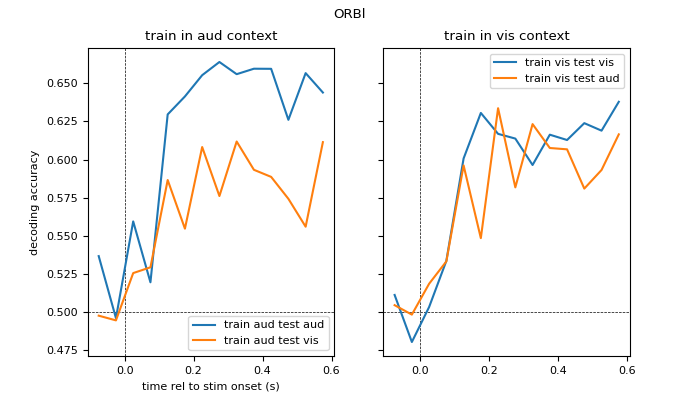

In [129]:
sel_structure='ORBl'

bin_centers=new_results_session_df.filter(
    pl.col('structure').eq(sel_structure),
    pl.col('train_test_split_label').eq('train_aud_test_aud'),   
)['bin_center'].item()

train_aud_test_aud=new_results_session_df.filter(
    pl.col('structure').eq(sel_structure),
    pl.col('train_test_split_label').eq('train_aud_test_aud'),   
)['balanced_accuracy_test'].item()

train_aud_test_vis=new_results_session_df.filter(
    pl.col('structure').eq(sel_structure),
    pl.col('train_test_split_label').eq('train_aud_test_vis'),   
)['balanced_accuracy_test'].item()

train_vis_test_vis=new_results_session_df.filter(
    pl.col('structure').eq(sel_structure),
    pl.col('train_test_split_label').eq('train_vis_test_vis'),   
)['balanced_accuracy_test'].item()

train_vis_test_aud=new_results_session_df.filter(
    pl.col('structure').eq(sel_structure),
    pl.col('train_test_split_label').eq('train_vis_test_aud'),   
)['balanced_accuracy_test'].item()


fig,ax=plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax[0].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
ax[0].axvline(0,color='k',linewidth=0.5,linestyle='--')
ax[0].plot(bin_centers,train_aud_test_aud,label='train aud test aud')
ax[0].plot(bin_centers,train_aud_test_vis,label='train aud test vis')
ax[0].set_xlabel('time rel to stim onset (s)')
ax[0].set_ylabel('decoding accuracy')
ax[0].set_title('train in aud context')
ax[0].legend()

ax[1].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
ax[1].axvline(0,color='k',linewidth=0.5,linestyle='--')
ax[1].plot(bin_centers,train_vis_test_vis,label='train vis test vis')
ax[1].plot(bin_centers,train_vis_test_aud,label='train vis test aud')
ax[1].set_title('train in vis context')
ax[1].legend()

fig.suptitle(sel_structure)


In [116]:
new_results_session_df.filter(
    pl.col('structure').eq(sel_structure),
    pl.col('train_test_split_label').eq('train_aud_test_aud'),   
)['balanced_accuracy_test'].item()

""
f64
0.498703
0.510959
0.534633
0.579683
0.620124
…
0.658477
0.642691
0.634519


In [111]:
x

balanced_accuracy_test
list[f64]
"[0.498703, 0.510959, … 0.616641]"
